# <font color='Tomato'>Planejamento da Solução (IOT)</font>

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade "INSIDERS"
2. Conjunto de dados com as vendas de produtos durantes 1 ano (11/2015 - 12/2017)

## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
2. Relatório com as respostas das perguntas de negocio.

## Tasks - Processo

# 0.0. Imports

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import umap.umap_ as umap

from IPython.display import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn import cluster
from sklearn import metrics

## 0.1. Helper Functions

In [2]:
def descriptive_statistics(num_attr):
    # Central Tendency: mean, median
    c1 = pd.DataFrame(num_attr.apply(np.mean))
    c2 = pd.DataFrame(num_attr.apply(np.median))

    # Dispension: min, max, range, std, skew, kurtosis
    d1 = pd.DataFrame(num_attr.apply(min))
    d2 = pd.DataFrame(num_attr.apply(max))
    d3 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min()))
    d4 = pd.DataFrame(num_attr.apply(lambda x: x.std()))
    
    # Measures of Shape
    s1 = pd.DataFrame(num_attr.apply(lambda x: x.skew()))
    s2 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis()))

    # concat
    m = pd.concat([d1,d2,d3,c1,c2,d4,s1,s2], axis=1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Data

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimnesions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3. Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
df1 = df1.dropna(subset=['description', 'customer_id'])

print('Removed: {}%'.format(round((1-(df1.shape[0] / df_raw.shape[0])) * 100, 2)))

Removed: 24.93%


## 1.6. Change dtypes

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [11]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

## 1.7. Descriptive Statistics

In [12]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(include=['object'])

## 1.7.1. Numerical Attributes

In [13]:
descriptive_statistics(num_att)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,12.06,5.00,248.69,0.18,94317.56
1,unit_price,0.00,38970.00,38970.00,3.46,1.95,69.32,452.22,246924.54
2,customer_id,12346.00,18287.00,5941.00,15287.69,15152.00,1713.60,0.03,-1.18


**Notes:**
    
1. quantity: numero negativo e alto, pode ser retorno
2. unit_price: zero unidades? 

## 1.7.2. Categorical Attributes

In [14]:
cat_att.describe(include=['O'])

,invoice_no,stock_code,description,country
count,406829,406829,406829,406829
unique,22190,3684,3896,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,542,2077,2070,361878


### invoice_no

In [15]:
list_letter_invoice = df1.loc[~df1['invoice_no'].apply(lambda x: bool(re.search(r'^[0-9]+', x))), 'invoice_no'].tolist()
len(list_letter_invoice)

8905

### stock_code

In [16]:
list_letter_stock_code = df1.loc[~df1['stock_code'].apply(lambda x: bool(re.search(r'(^[0-9]+)$', x))), 'stock_code'].tolist()
len(list_letter_stock_code)

35809

### country

In [17]:
df1['country'].value_counts(normalize=True).head(10)

United Kingdom   0.89
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.01
Netherlands      0.01
Belgium          0.01
Switzerland      0.00
Portugal         0.00
Australia        0.00
Name: country, dtype: float64

**Notes**
1. invoice_no: 8905 items que não são somente numeros.
2. stock_code: 35809 items que não são somente numeros.
3. description: não tem informação relevante.

# 2.0. Feature Engineering

In [94]:
df2 = df1.copy()

## 2.1. Feature Creation

In [95]:
df_ref = df2.drop( columns=['invoice_no', 'stock_code', 'description', 'quantity', 
                            'invoice_date','unit_price', 'country'] ).drop_duplicates(ignore_index=True)

In [96]:
# monetary
df2.loc[:, 'gross_revenue'] = df2.loc[:, 'quantity'] * df2.loc[:, 'unit_price']

df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

In [97]:
# recency_days
df_recency = df2[['invoice_date', 'customer_id']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency.loc[:, 'invoice_date']).dt.days

df_ref = pd.merge(df_ref, df_recency[['recency_days', 'customer_id']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
dtype: int64

In [98]:
# frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq,  how='left', on='customer_id')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
dtype: int64

In [99]:
# avg ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# 3.0. Data Filtering 

In [100]:
df3 = df_ref.copy()

# 4.0. EDA  

In [101]:
df4 = df3.copy()

# 5.0. Data Preparation 

In [102]:
df5 = df4.copy()

# 6.0. Feature Selection

In [103]:
df6 = df5.copy()

# 7.0. Hyperpameter Fine Tuning

In [105]:
X = df6.drop(columns=['customer_id'])

In [106]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.95
1,3079.10,31,18,15.71
2,7187.34,2,18,28.63
3,948.25,95,5,33.87
4,635.10,330,6,105.85


In [112]:
clusters = [2,3,4,5,6,7]

## KMeans

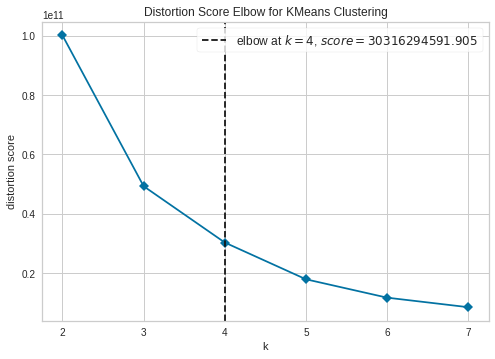

In [115]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show();

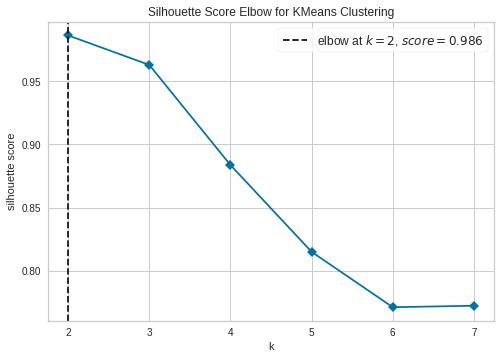

In [116]:
km = KElbowVisualizer(cluster.KMeans(), k=clusters, metric='silhouette', timings=False)
km.fit( X )
km.show();

## 7.1. Silhouette Analysis

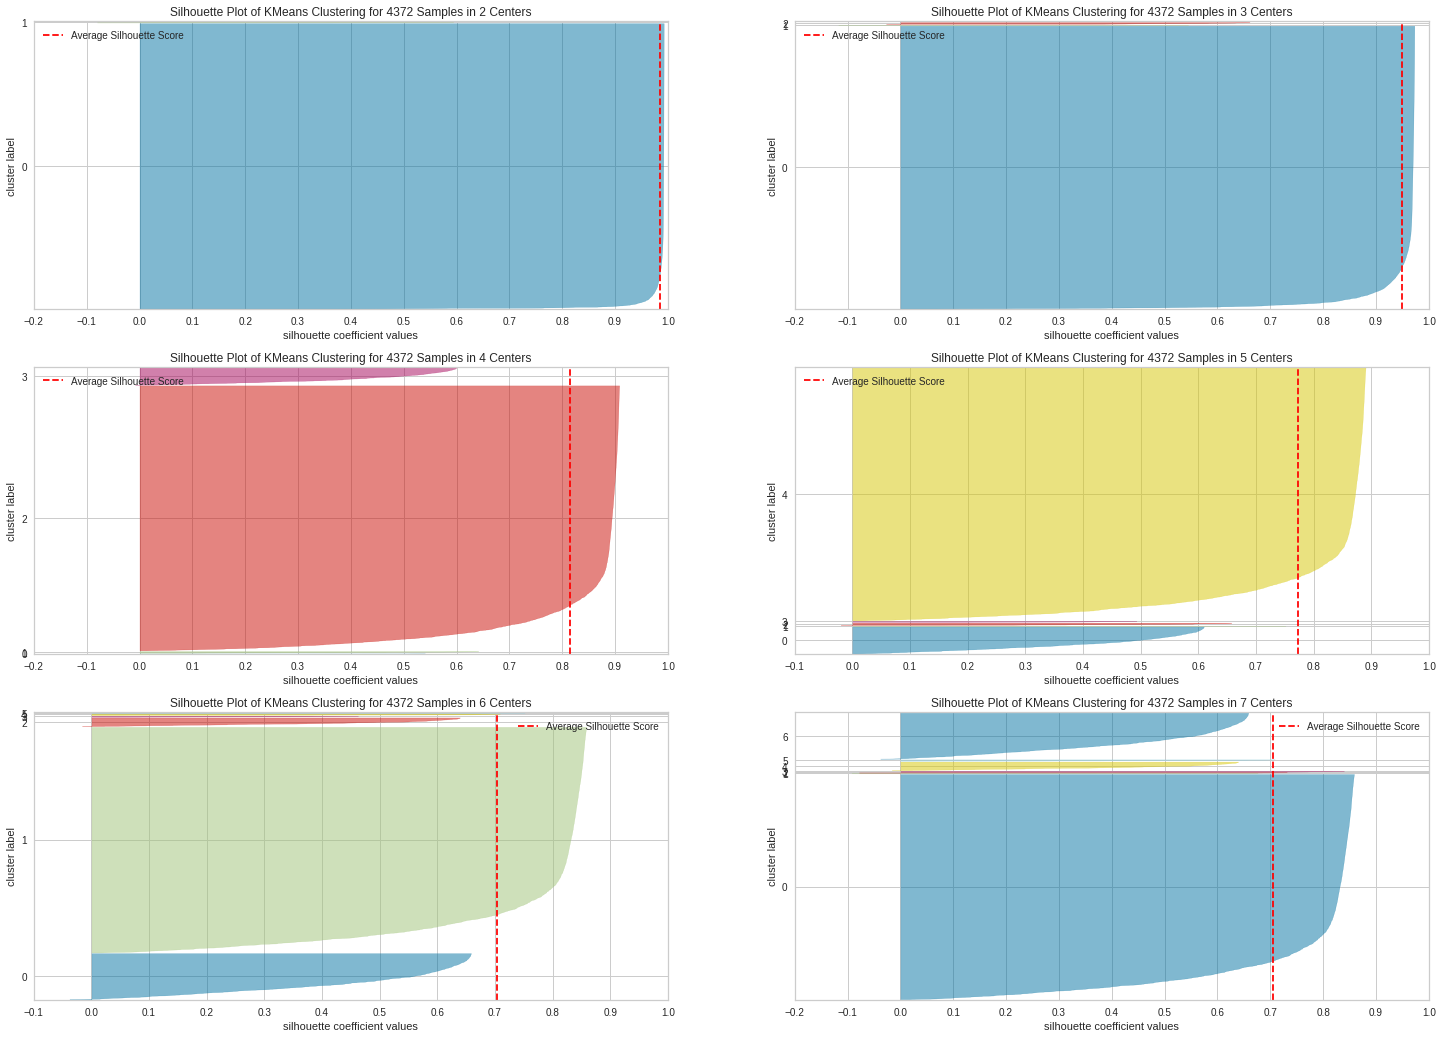

In [119]:
fig, ax = plt.subplots(3,2, figsize=(25, 18))

for k in clusters:
    km = cluster.KMeans(n_clusters=k, init='random', n_init=10, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize();

# 8.0. Model Training

## 8.1. K-Means

In [120]:
# model definition
k = 4
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [125]:
metrics.silhouette_score(X, labels, metric='euclidean')

0.8139972028952444

In [126]:
print('WSS value: {}'.format( kmeans.inertia_ ))
print('SS value: {}'.format( metrics.silhouette_score(X, labels, metric='euclidean') ))

WSS value: 40056254626.3
SS value: 0.8139972028952444


# 9.0. Cluster Analysis

In [161]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850.00,5288.63,302,35,16.95,1
1,13047.00,3079.10,31,18,15.71,3
2,12583.00,7187.34,2,18,28.63,1
3,13748.00,948.25,95,5,33.87,3
4,15100.00,635.10,330,6,105.85,3


## 9.1. Visualization Inspection

### 9.1.1. Silhouette Analysis

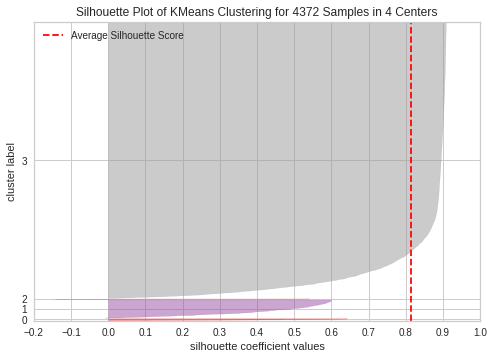

In [128]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit( X )
visualizer.finalize();

### 9.1.2 2d plot

In [135]:
df_viz = df9.drop(columns='customer_id')

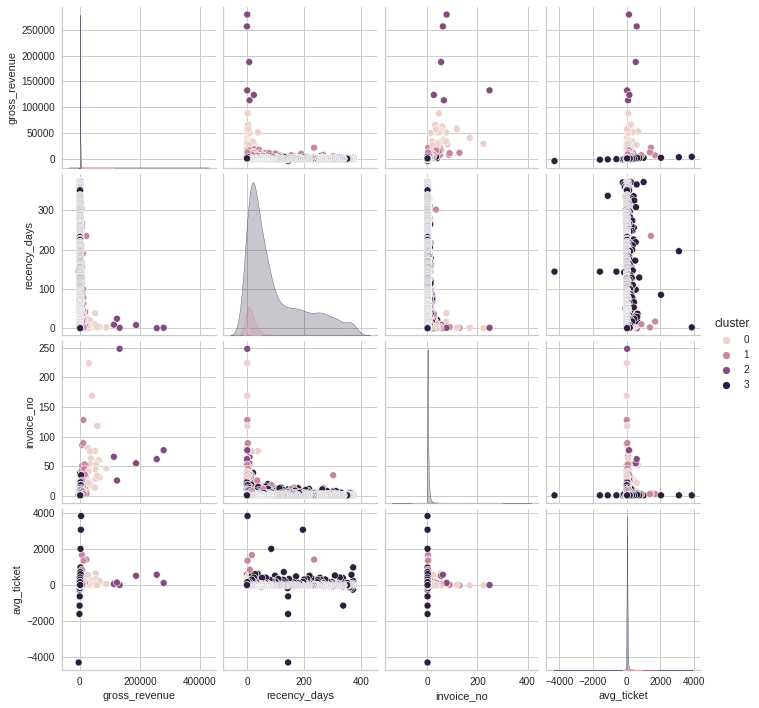

In [130]:
sns.pairplot(df_viz, hue='cluster');

### 9.1.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

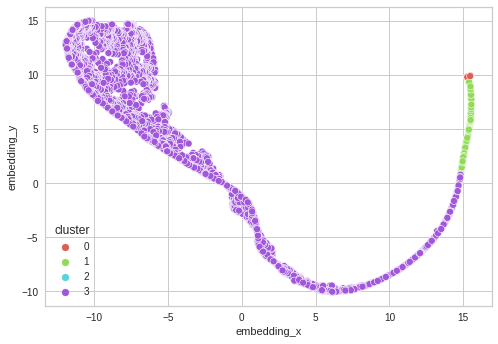

In [141]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform( X )

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profile

In [162]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850.00,5288.63,302,35,16.95,1
1,13047.00,3079.10,31,18,15.71,3
2,12583.00,7187.34,2,18,28.63,1
3,13748.00,948.25,95,5,33.87,3
4,15100.00,635.10,330,6,105.85,3


In [163]:
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'qt_users'})

# gross_revenue
gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, gross_revenue, how='left', on='cluster')

df_cluster['per_user'] = 100 * (df_cluster['qt_users'] / df_cluster['qt_users'].sum())
# recency_days
recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, recency_days, how='left', on='cluster')

# recency_days
invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'invoice_no': 'frequency'})
df_cluster = pd.merge(df_cluster, invoice_no, how='left', on='cluster')


df_cluster

,cluster,qt_users,gross_revenue,per_user,recency_days,frequency
0,0,28,42614.39,0.64,6.18,57.82
1,1,267,8089.03,6.11,20.28,19.53
2,2,6,182181.98,0.14,7.17,89.00
3,3,4071,946.70,93.12,96.97,3.64


# 10.0. Deploy to Product